# Fitting with autograd

Let's import some libraries and define a helper function:

In [17]:
%matplotlib inline

import autograd.numpy as np
from autograd.scipy.stats import norm
from autograd import grad, hessian
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# For mapping values in (0, 1) to (-inf, +inf)
def expit(x):
    return 1 / (1 + np.exp(-x))

Let's generate a random dataset:

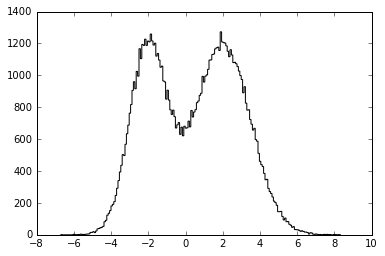

In [18]:
N = 100000
N1 = np.random.binomial(N, 0.4)
X1 = np.random.normal(-2, 1, N1)
X2 = np.random.normal(2, 1.5, N - N1)
X = np.append(X1, X2)

plt.hist(X, histtype='step', color='k', bins=200);

Define the likelihood model.

Note that I mapped parameters bounded below by 0 to ones on (-inf, inf) and likewise for ones on (0, 1) to (-inf, +inf).

Instead of naively calculating $\log(f * \exp(p_1) + (1 - f) * \exp(p_2))$, I use the log-sum-exp trick.


In [19]:
def logpdf(params, data):
    f = params['f']
    mu1 = params['mu1']
    mu2 = params['mu2']
    sigma1 = params['sigma1']
    sigma2 = params['sigma2']

    p1 = np.log(expit(f)) + norm.logpdf(data, mu1, np.exp(sigma1))
    p2 = np.log(1 - expit(f)) + norm.logpdf(data, mu2, np.exp(sigma2))

    return np.logaddexp(p1, p2)

From this, we can construct the log-likelihood for the model with some helpful logging output

In [20]:
def ll(params, data):
    out = np.sum(logpdf(params, data))
    if isinstance(out, np.float64):
        print(out)
    return out

The objective function (that needs to be minimized) is given by

In [21]:
data = X

def objective(x):
    params = dict()
    params['f'], params['mu1'], params['mu2'], params['sigma1'], params['sigma2'] = x 

    out = -ll(params, data)
    if np.isnan(out):
        raise ValueError("Illegal probability encountered at {}".format(params))
    return out

Now, we can use the `autograd` library to get the gradient and hessian of the objective function.

In [22]:
gradient = grad(objective)
hess = hessian(objective)

For the optimization, we use `scipy.optimize` with some terribly wrong initial values:

In [23]:
out = minimize(objective, jac=gradient, x0=[-3, -3, 3, 1, -1], method='L-BFGS-B')

-442770.185088
-325866.959365
-293026.634957
-235160.946548
-240483.273636
-225903.288555
-222531.149637
-221215.701022
-220459.306516
-220348.844488
-220213.02008
-219992.734087
-219757.599445
-219622.435724
-219534.412677
-219525.28318
-219525.039083
-219525.010259
-219525.008819
-219525.008748


The minimization has finished, and we can overlay the model on top of our data

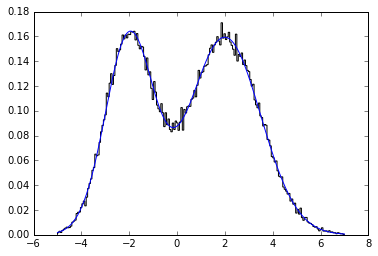

In [26]:
params = dict()
params['f'], params['mu1'], params['mu2'], params['sigma1'], params['sigma2'] = out.x
xs = np.linspace(-5, 7, 200)
plt.hist(data, histtype='step', color='k', bins=200, range=(-5, 7), normed=True)
f = lambda xs: np.exp(logpdf(params, xs))
plt.plot(xs, f(xs))

If we're interested in the errors on our parameters, we can get them from the fisher information:

In [28]:
hs = hess(out.x)
cov = np.linalg.inv(hs)
err = np.sqrt(np.diag(cov))

for x, e in zip(out.x, err):
    print(x, e)

-0.399848771353 0.0104203415992
-1.99967054954 0.00859753196565
1.99448598671 0.0105927661859
0.00393739343292 0.00578702226849
0.404863029427 0.00503073097642
